In [5]:
%load_ext autoreload
%autoreload 2

import torch
from model import PointNet
from dataset import lm2flat_index
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from itertools import cycle, islice

def repeatlist(it, count):
    return islice(cycle(it), count)

In [34]:
from typing import List, Tuple
from dataset import OctantDataset
from torch.utils.data import DataLoader
from pytorch3d.structures import Pointclouds
import torch.utils.data as data

ds = OctantDataset("../datasets/neuschwanstein_sh",sub_sample=1000)

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)

num_train = int(0.8*len(ds))

ds_train, ds_val = data.random_split(ds,[num_train,len(ds)-num_train])

batch_size = 64

train_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=12,pin_memory=True
)
val_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=False,num_workers=3,pin_memory=True
)
len(ds_train),len(ds_val)

(800, 200)

In [35]:
l = 5
model = PointNet((l + 1) ** 2,batch_norm=False).cuda()

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

0it [00:00, ?it/s]

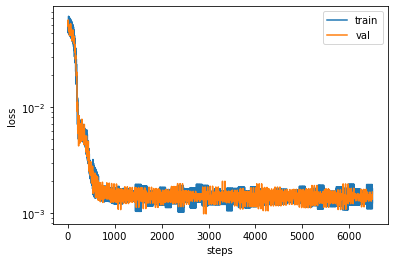

In [36]:
from torch.optim.lr_scheduler import OneCycleLR
epochs = 50

scheduler = OneCycleLR(optimizer,max_lr=1e-3,steps_per_epoch=len(train_dataloader)*10,epochs=epochs,pct_start=0.1,three_phase=True)

mse_loss = torch.nn.MSELoss()

def unpack_data(pcs:Pointclouds):
    vertices = pcs.points_packed().cuda()
    color = (pcs.features_packed()[:, :3]).cuda().float() / 255.0
    batch = pcs.packed_to_cloud_idx().cuda()
    return vertices,color,batch


loss_hist_train = {}
loss_hist_val = {}
step=0

with tqdm(len(train_dataloader)*10) as pbar:
    for epoch in range(epochs):
        # print(f"lr: {scheduler.get_last_lr()}")

        pbar.reset(len(train_dataloader)*10)
        pbar.set_description(f"epoch {epoch+1}/{epochs}")

        val_sampler = repeatlist(iter(val_dataloader),len(val_dataloader)*10)

        for i,(pcs, coefs) in enumerate(repeatlist(iter(train_dataloader),len(train_dataloader)*10)):
            model.train()
            vertices,color,batch = unpack_data(pcs)
            target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
            optimizer.zero_grad()

            pred_coefs = model(vertices, color, batch)
            train_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
            train_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.)
            optimizer.step()
            loss_hist_train[step] = train_loss.item()
            scheduler.step()

            # do validation batch every 4th train batch
            if i%4 == 0:
                model.eval()
                pcs,coefs = next(val_sampler)
                vertices,color,batch = unpack_data(pcs)
                target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
                pred_coefs = model(vertices, color, batch)
                val_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
                loss_hist_val[step] = val_loss.item()

            pbar.update()
            step+=1

plt.plot(loss_hist_train.keys(),loss_hist_train.values(), label="train")
plt.plot(loss_hist_val.keys(),loss_hist_val.values(), label="val")
plt.legend()
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale("log")


In [37]:
from sh import calc_sh

res = 100


x = torch.arange(0,1,1/res)
grid_x,grid_y = torch.meshgrid(x*torch.pi,x*2*torch.pi,indexing="ij")
coords = torch.stack((grid_x.flatten(),grid_y.flatten())).T

y = calc_sh(l,coords)

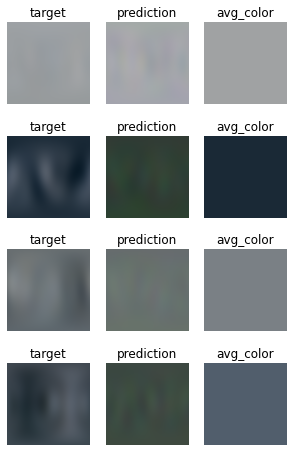

In [50]:
model.eval()
model.requires_grad_(False)

pc,a_lm = next(iter(train_dataloader))

pred_a = model(*unpack_data(pc)).squeeze(0)
a_lm = a_lm[:,:lm2flat_index(l, -l) + 1]

fig,axes = plt.subplots(4,3,figsize=(5,8))

for i in range(4):
    ax1,ax2,ax3 = axes[i]
    ax1.set_title("target")
    ax1.set_axis_off()
    ax1.imshow((y@a_lm[i].cpu()).reshape(res,res,-1))

    ax2.set_title("prediction")
    ax2.set_axis_off()
    ax2.imshow((y@pred_a[i].cpu()).reshape(res,res,-1))

    ax3.set_title("avg_color")
    ax3.set_axis_off()
    ax3.imshow(pc.features_list()[i].float().mean(dim=0).reshape((1,1,4)).int())

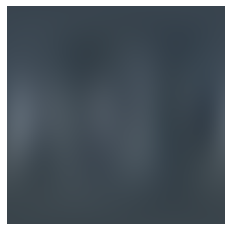

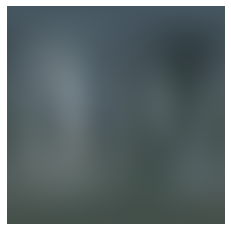

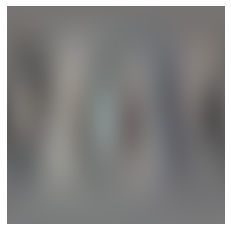

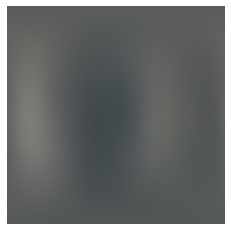

In [12]:
model.eval()
model.requires_grad_(False)

pc,a_lm = next(iter(train_dataloader))

pred_a = model(*unpack_data(pc)).squeeze(0)
a_lm = a_lm[:,:lm2flat_index(l, -l) + 1]

for i in range(4):
    plt.axis("off")
    plt.imshow((y@a_lm[i].cpu()).reshape(res,res,-1))
    plt.show()

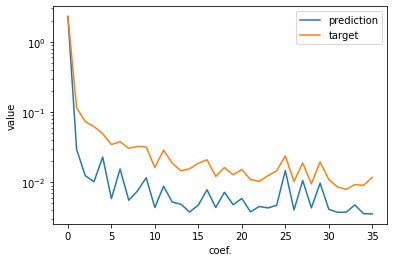

In [16]:
plt.ylabel("value")
plt.xlabel("coef.")
# plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.plot((pred_a.cpu()).norm(2,-1).mean(0),label="prediction")
plt.plot((a_lm.cpu()).norm(2,-1).mean(0),label="target")
plt.legend()
plt.yscale("log")

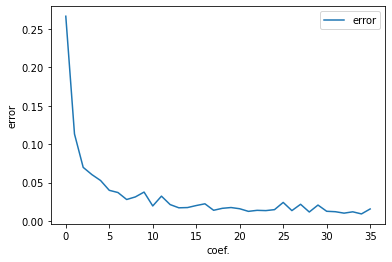

In [39]:
plt.ylabel("error")
plt.xlabel("coef.")
plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.legend()
# plt.yscale("log")

(array([ 5.,  4.,  7.,  6.,  3.,  5., 13.,  4., 15., 19., 22., 22., 44.,
        44., 61., 47., 46., 40., 27., 44., 39., 29., 33., 24., 31., 25.,
        22., 26., 19., 19., 19., 17., 22., 21., 16., 10., 15., 10., 11.,
        12., 19., 11., 11., 10.,  8.,  9.,  7.,  8.,  5., 14.]),
 array([   7.  ,   27.28,   47.56,   67.84,   88.12,  108.4 ,  128.68,
         148.96,  169.24,  189.52,  209.8 ,  230.08,  250.36,  270.64,
         290.92,  311.2 ,  331.48,  351.76,  372.04,  392.32,  412.6 ,
         432.88,  453.16,  473.44,  493.72,  514.  ,  534.28,  554.56,
         574.84,  595.12,  615.4 ,  635.68,  655.96,  676.24,  696.52,
         716.8 ,  737.08,  757.36,  777.64,  797.92,  818.2 ,  838.48,
         858.76,  879.04,  899.32,  919.6 ,  939.88,  960.16,  980.44,
        1000.72, 1021.  ]),
 <BarContainer object of 50 artists>)

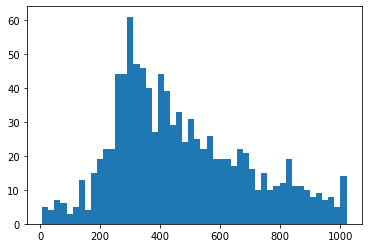

In [54]:
plt.hist([pc.points_packed().shape[0] for (pc,_) in ds],bins=50)
    